#  Extracting functional brain atlas:

Before analyzing functional connectivity, we need to reduce the dimensionality of the problem. To do that, we estimate an atlas directly on our data.

In this tutorial we will learn:
* How to download the ADHD dataset
* How to compute a brain mask
* How to use Group ICA and Dictionary Learning provided by Nilearn.

In [11]:
%matplotlib inline

## Loading the data

Nilearn provides a bunch of automatic downloaders to ease reproducibility of the analysis. With nilearn, an analysis is run in a single script and can be shared easily.

The nilearn fetchers can be found in the module `nilearn.datasets`.

In [6]:
from nilearn import datasets

# parameter n_subjects=None gives us all the subjects
# We download 10 subjects for this example
data = datasets.fetch_adhd(n_subjects=3)

# We look at the available data in this dataset.
print(data.keys())

# Functional datasets are stored in variable 'func'
func = data.func

# We take a look at where the data is loaded
print(func[0])

# Phenotypic or demographic variables are stored in 'phenotypic'
phenotypic = data.phenotypic

['phenotypic', 'confounds', 'description', 'func']
/home/aa013911/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


#### NOTE: All the datasets are stored locally and nilearn is comfortable processing data by giving the paths of the data storage location. 

## Computing a brain atlas

Several reference atlases are available in nilearn. We also provide functions to compute a brain atlas directly from the data.

We provide:
* an efficient group ICA implementation (`nilearn.decomposition.CanICA`)
* an efficient Dictionary Learning implementation (`nilearn.implementation.DictLearning`)

In [7]:
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20)
canica.fit(func)

CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
    mask_args=None, mask_strategy='epi', memory=Memory(cachedir=None),
    memory_level=0, n_components=20, n_init=10, n_jobs=1,
    random_state=None, smoothing_fwhm=6, standardize=True, t_r=None,
    target_affine=None, target_shape=None, threshold='auto', verbose=0)

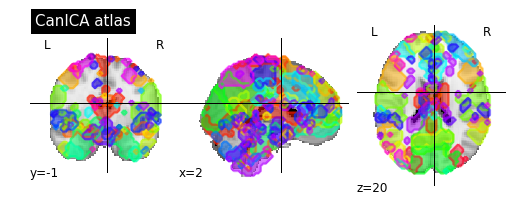

In [24]:
components_img = canica.masker_.inverse_transform(canica.components_)

# We visualize the generated atlas
from nilearn import plotting

plotting.plot_prob_atlas(components_img, title='CanICA atlas', threshold=1e-10)

## Extracting subject specific timeseries signals from brain parcellations

Computing mask from the data, filtering, extracting data from the in-mask voxels can be processed easily by using nilearn classes such as NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker which can be imported from nilearn.input_data module.

The advantage of using such tools from this module is that we can restrict our analysis to mask specific voxels timeseries data. For instance, class `NiftiMasker` can be used to compute mask over the data and apply preprocessing steps such as filtering, smoothing, standardizing and detrending on voxels timeseries signals. This type of processing is very much necessary, particularly during resting state fMRI data analysis.

Additional to `NiftiMasker`, classes `NiftiMapsMasker` and `NiftiLabelsMasker`, can be used to extract subject specific timeseries signals on each subject data provided with the atlas maps (3D or 4D) comprising of specific brain regions. `NiftiMapsMasker` operated on 4D atlas maps, can be used to extract signals from each 4th dimensional map using least squares regression. Whereas, `NiftiLabelsMasker` operated on 3D maps denoted as labels image, can be used to extract averaged timeseries from group of voxels that correponds to each label in the image.


In [17]:
# Import and initialize `NiftiMapsMasker` object and call `fit_transform` to
# extract timeseries signals from computed atlas.
from nilearn.input_data import NiftiMapsMasker

# The parameters used are maps_img as parcellations, resampling to maps image,
# smoothing of 6mm, detrending, standardizing and filtering (TR in sec). These later
# parameters are applied automatically when extracting timeseries data.
masker = NiftiMapsMasker(components_img,
                         smoothing_fwhm=6, standardize=True, detrend=True,
                         t_r=2.5, low_pass=0.1, high_pass=0.01)

print(masker) # to see the initialization of the parameters.

NiftiMapsMasker(allow_overlap=True, detrend=True, high_pass=0.01,
        low_pass=0.1,
        maps_img=<nibabel.nifti1.Nifti1Image object at 0x7ff1092d8e10>,
        mask_img=None, memory=Memory(cachedir=None), memory_level=0,
        resampling_target='data', smoothing_fwhm=6, standardize=True,
        t_r=2.5, verbose=0)


# Extracting time series for each subject

We loop over the subjects to extract time series

In [19]:
subjects_timeseries = []
for subject_func in func:
    subjects_timeseries.append(masker.fit_transform(subject_func))

print("Finished extracting timeseries signals for each subject")

Finished extracting timeseries signals for each subject


(176, 20)


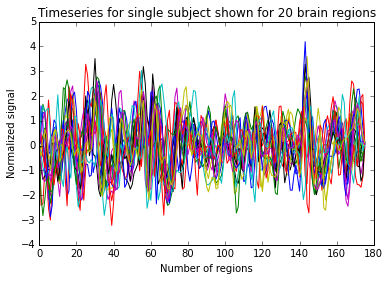

In [20]:
# Visualizing extracted timeseries signals. We import matplotlib.pyplot
import matplotlib.pyplot as plt

# We show thel for a single subject
timeseries = subjects_timeseries[0]
print(timeseries.shape) # (number of scans/time points, number of brain regions/parcellations)
plt.plot(timeseries)
plt.title('Timeseries for single subject shown for 20 brain regions')
plt.xlabel('Number of regions')
plt.ylabel('Normalized signal')
plt.show()

# Running online dictionary learning

Apart from small specificities, decomposition models can be swapped in the code seamlessly. We now run a dictionary learning on the same data and visualize it.

In [ ]:
dict_learn = decomposition.DictLearning(n_components=20, alpha=.5)
dict_learn.fit(func)
components_img = dict_learn.masker_.inverse_transform(dict_learn.components_)

# We visualize the generated atlas
from nilearn import plotting

plotting.plot_prob_atlas(components_img, title='DictLearning atlas', threshold=1e-10)

## Extracting a brain atlas using KMeans from scikit-learn

Nilearn provides specific methods to segment brain from functional signals but it is also possible to rely on classic clustering techniques by using scikit-learn directly.

# Extracting regions from computed atlas

XXX